In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib
import custom_funcs as cf

In this notebook, I will train plain vanilla RandomForestRegressor models for each of the protease drug resistance values, and pickle them to disk.

In [65]:
drugs = ['FPV', 'ATV', 'IDV', 'LPV', 'NFV', 'SQV', 'TPV', 'DRV',]
drug = drugs[1]
protein = 'protease'

data, feat_cols = cf.get_cleaned_data(protein, drug)

# Just checking:
cf.test_data_integrity(data)

## Now, let's do data transformations.
data_numeric = cf.to_numeric_rep(data, feat_cols, rep='mw')

# Finally, split the data into a training set, and test set.
X, Y, X_train, X_test, Y_train, Y_test = cf.to_train_test_split(data_numeric, feat_cols, drug, test_size=0.3)
# sscv = ShuffleSplit(n=len(X_train), n_iter=3, test_size=0.3)

In [78]:
mdl = RandomForestRegressor(n_estimators=2000, min_samples_leaf=1, n_jobs=-1, )
mdl.fit(X, Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=2000, n_jobs=-1, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [79]:
import numpy as np

def pred_intervals(model, X, percentile=95):
    """
    From http://blog.datadive.net/prediction-intervals-for-random-forests/
    
    Computes prediction intervals to compute uncertainty.
    """
    err_down = []
    err_up = []
    avg_preds = []
    for row in range(len(X)):
        # print(x)
        preds = []
        for est in model.estimators_:
            preds.append(est.predict(X[row].reshape(1, -1))[0])
        err_down.append(np.percentile(preds, (100 - percentile) / 2. ))
        err_up.append(np.percentile(preds, 100 - (100 - percentile) / 2.))
        avg_preds.append(np.mean(preds))
    return err_down, err_up, avg_preds

In [80]:
%%time
err_down, err_up, avg_preds = pred_intervals(mdl, X_test.values)
err_down, err_up, avg_preds

CPU times: user 16.4 s, sys: 149 ms, total: 16.6 s
Wall time: 16.8 s


In [81]:
yerr_down = np.array(avg_preds) - np.array(err_down)
yerr_up = np.array(err_up) - np.array(avg_preds)

In [82]:
for i in range(len(err_down)):
    assert err_down[i] < avg_preds[i]
    assert err_up[i] > avg_preds[i]

In [83]:
yerr_down

array([ 1.34581216,  1.3374454 ,  0.14951131,  0.04257836,  0.10528172,
        1.40624103,  0.09899819,  0.27592575,  0.13774086,  0.46672282,
        0.08272831,  1.20115604,  0.69540971,  0.31340395,  1.49362763,
        0.46848017,  0.18504843,  0.12036478,  0.38694632,  0.25779663,
        0.59256126,  0.93516762,  0.82528292,  0.28261072,  0.36925949,
        0.76019734,  0.73798245,  0.22549988,  1.03952084,  0.2285614 ,
        0.49367395,  1.57509538,  0.56119773,  0.11948914,  0.3389982 ,
        0.25811194,  0.10145228,  0.1849652 ,  0.14039323,  0.43281609,
        0.20953997,  1.39180421,  0.26463179,  0.3389982 ,  1.26962166,
        0.27031018,  1.0089561 ,  0.52287361,  0.15615351,  0.18814938,
        0.29285376,  1.24297955,  0.20896827,  0.16463502,  0.55957758,
        0.63188606,  0.199348  ,  0.78528107,  0.22933356,  0.09506351,
        0.24859282,  0.9236156 ,  1.39146289,  0.1755381 ,  1.36082899,
        0.23891972,  1.55382508,  0.85743623,  1.35373767,  0.86

In [84]:
preds = mdl.predict(X_test.values)

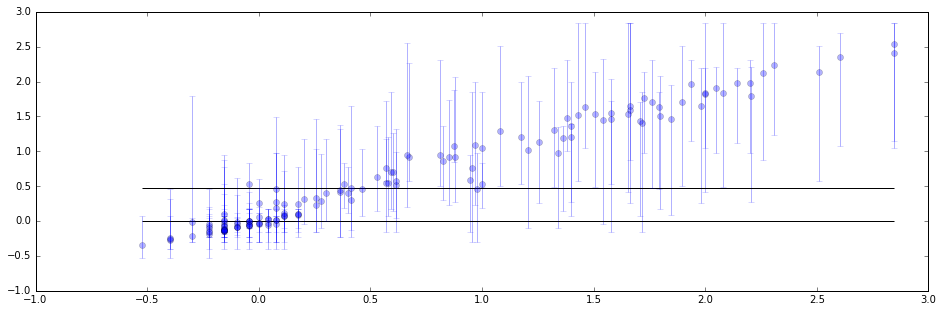

In [85]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(16, 5))
plt.errorbar(Y_test.values, avg_preds, yerr=[yerr_down, yerr_up], marker='o', ls='none', alpha=0.3)
# plt.xlim(-1.5, 3)
# plt.ylim(-1.5, 3)
plt.hlines(y=[0, np.log10(3)], xmin=min(Y_test.values), xmax=max(Y_test.values))

In [86]:
joblib.dump(mdl, '../models/base/{drug}/{drug}.pkl'.format(drug=drug))

['../models/base/ATV/ATV.pkl',
 '../models/base/ATV/ATV.pkl_01.npy',
 '../models/base/ATV/ATV.pkl_02.npy',
 '../models/base/ATV/ATV.pkl_03.npy',
 '../models/base/ATV/ATV.pkl_04.npy',
 '../models/base/ATV/ATV.pkl_05.npy',
 '../models/base/ATV/ATV.pkl_06.npy',
 '../models/base/ATV/ATV.pkl_07.npy',
 '../models/base/ATV/ATV.pkl_08.npy',
 '../models/base/ATV/ATV.pkl_09.npy',
 '../models/base/ATV/ATV.pkl_10.npy',
 '../models/base/ATV/ATV.pkl_11.npy',
 '../models/base/ATV/ATV.pkl_12.npy',
 '../models/base/ATV/ATV.pkl_13.npy',
 '../models/base/ATV/ATV.pkl_14.npy',
 '../models/base/ATV/ATV.pkl_15.npy',
 '../models/base/ATV/ATV.pkl_16.npy',
 '../models/base/ATV/ATV.pkl_17.npy',
 '../models/base/ATV/ATV.pkl_18.npy',
 '../models/base/ATV/ATV.pkl_19.npy',
 '../models/base/ATV/ATV.pkl_20.npy',
 '../models/base/ATV/ATV.pkl_21.npy',
 '../models/base/ATV/ATV.pkl_22.npy',
 '../models/base/ATV/ATV.pkl_23.npy',
 '../models/base/ATV/ATV.pkl_24.npy',
 '../models/base/ATV/ATV.pkl_25.npy',
 '../models/base/AT